In [1]:
import yt
from yt import YTArray
from yt import YTQuantity

from astropy import constants as const

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import SymLogNorm, LogNorm

import palettable
import plotting_tools as pt
import yt_functions as ytf


yt : [INFO     ] 2019-12-12 12:11:53,419 Parameters: current_time              = 0
yt : [INFO     ] 2019-12-12 12:11:53,421 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-12-12 12:11:53,422 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-12-12 12:11:53,423 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-12-12 12:11:53,424 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2019-12-12 12:26:23,091 Parameters: current_time              = 0.15000000508429
yt : [INFO     ] 2019-12-12 12:26:23,092 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-12-12 12:26:23,093 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-12-12 12:26:23,094 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-12-12 12:26:23,095 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-12 12:26:23,102 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-12-12 12:26:23,912 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-12-12 12:26:23,913 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-12-12 12:26:23,915 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-12-12 12:26:23,916 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-12-12 12:26:23,918 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-12-12 12:26:23,942 Making a fixed resolution b

0


yt : [INFO     ] 2019-12-12 12:27:26,600 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-12-12 12:27:27,037 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-12-12 12:27:31,030 Projection completed
yt : [INFO     ] 2019-12-12 12:27:31,043 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-12-12 12:27:36,038 Projection completed
yt : [INFO     ] 2019-12-12 12:27:36,055 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-12-12 12:27:36,616 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2019-12-12 12:27:42,009 Projection completed


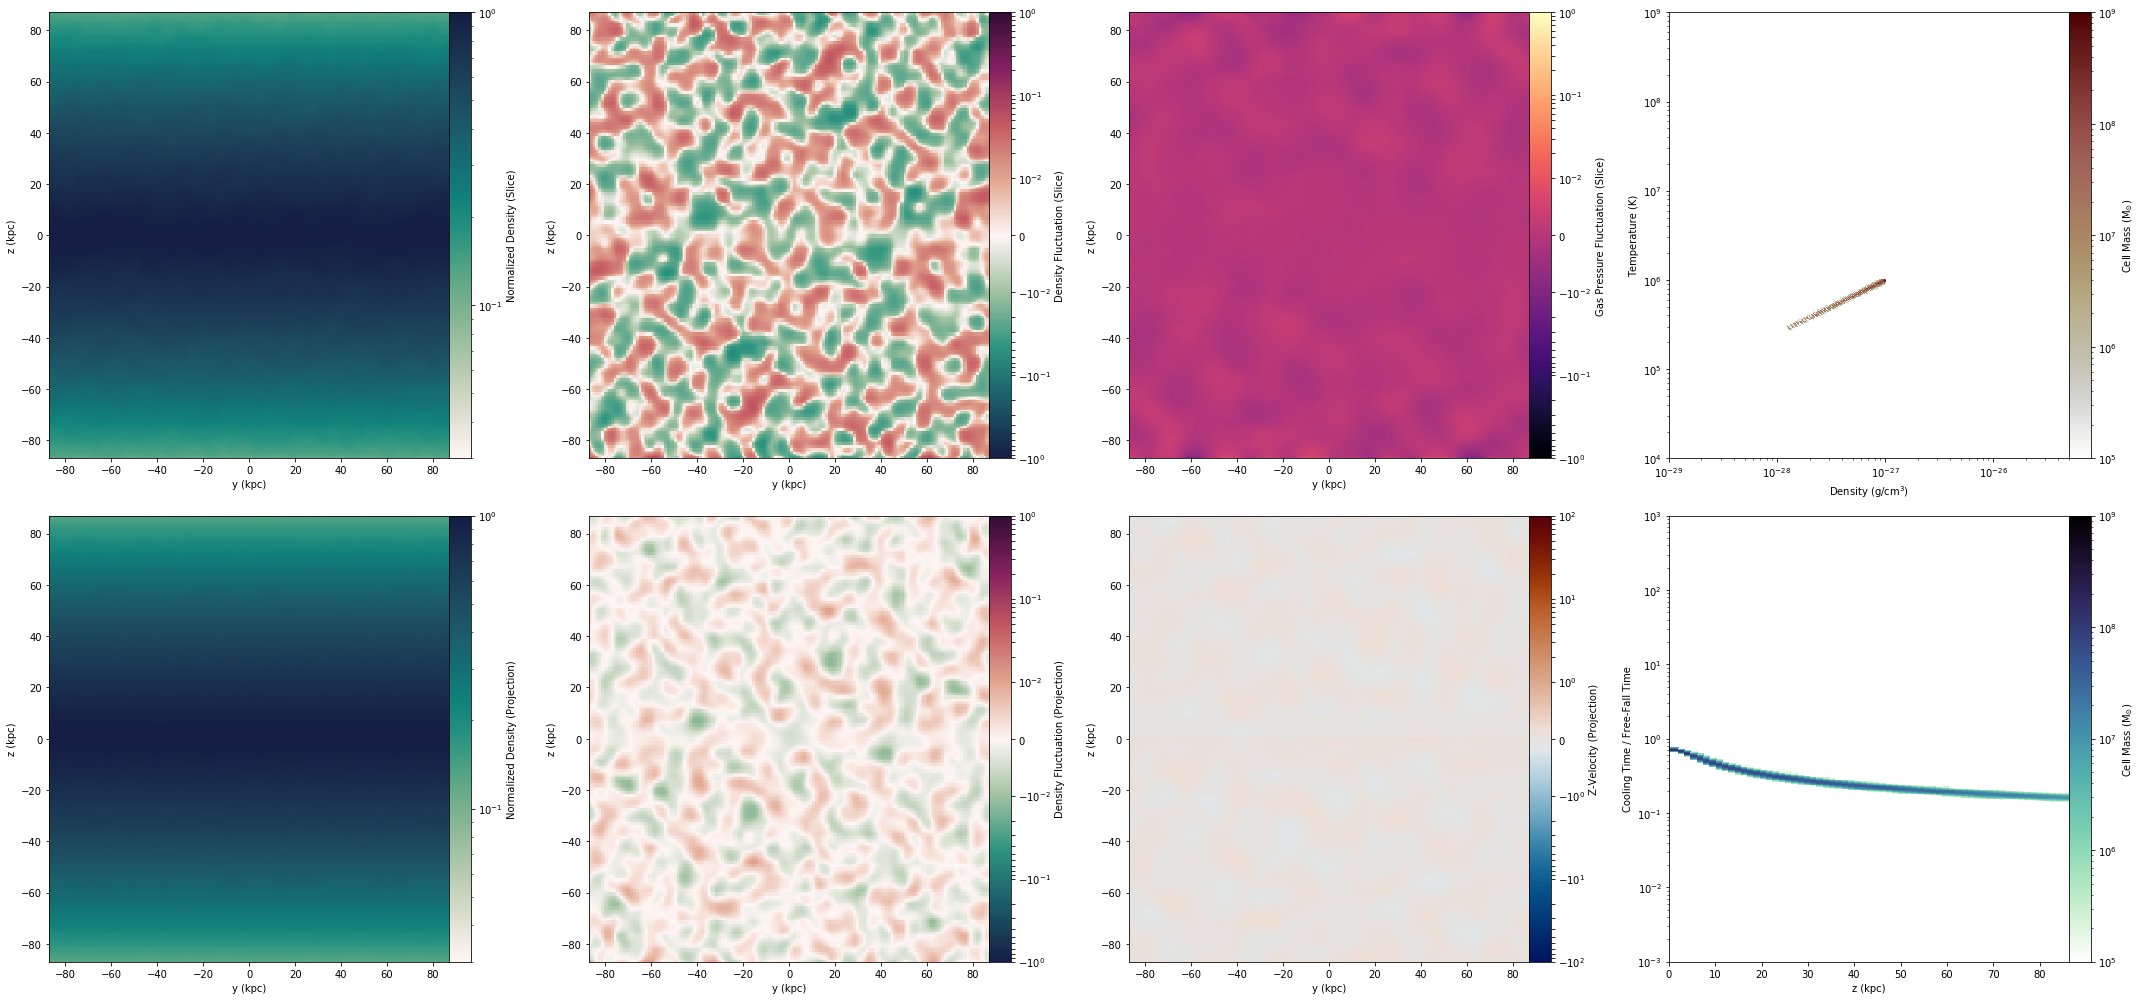

In [5]:
i = 5

#folder = 'isothermal_tctf_0.1_beta_10.0_cr_0.1_diff_1.0'
folder = 'isocool_tctf_0.3_2d_256'
folder = 'isocool_tctf_0.3'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))

fig, ax = pt.plot_density_slices(ds)

yt : [INFO     ] 2019-12-09 15:06:41,612 Parameters: current_time              = 0.19999990153173
yt : [INFO     ] 2019-12-09 15:06:41,613 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-12-09 15:06:41,614 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-12-09 15:06:41,615 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-12-09 15:06:41,616 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-09 15:06:41,639 Gathering a field list (this may take a moment.)
/home/ibutsky/yt/yt/units/yt_array.py:1400: RuntimeWarning: divide by zero encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2019-12-09 15:06:42,697 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-09 15:06:42,698 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-09 15:06:42,700 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-09 15:06:42,700 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-09 15:06:42,702 Making a fixe


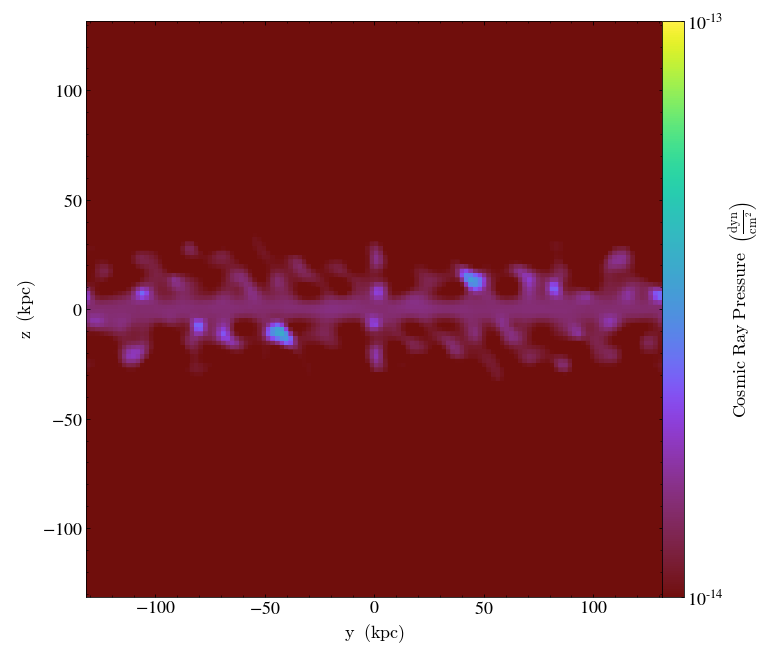
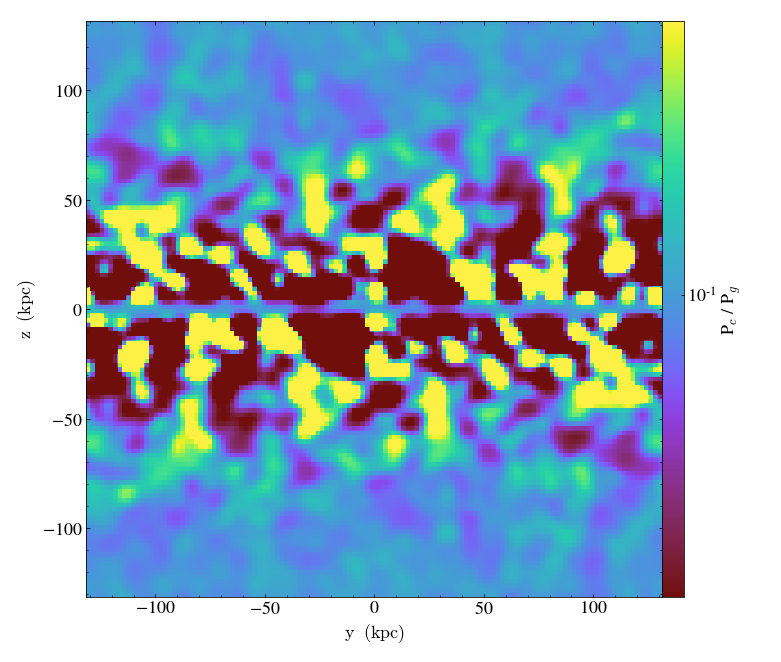

In [58]:
i = 20
folder = 'isothermal_tctf_0.1_beta_10.0_cr_0.1'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
s = yt.SlicePlot(ds, 'x', [('gas', 'cr_eta'), ('gas', 'cr_pressure')])
s.set_zlim(('gas', 'cr_eta'), .09, .11)
#s.set_zlim(('gas', 'cr_eta'), 9, 11)

s.set_zlim(('gas', 'cr_pressure'), 1e-14, 1e-13)
s.show()

In [57]:
1000000000000000019884624838656.000000 / 1e30


1.0

yt : [INFO     ] 2019-12-08 07:46:46,510 Parameters: current_time              = 0.51999990029784
yt : [INFO     ] 2019-12-08 07:46:46,511 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-12-08 07:46:46,512 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-12-08 07:46:46,513 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-12-08 07:46:46,514 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-08 07:46:46,553 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-12-08 07:46:47,427 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:46:47,428 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:46:47,429 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:46:47,430 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:46:47,431 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-12-08 07:46:47,446 Making a fixed resolution b

0


yt : [INFO     ] 2019-12-08 07:47:47,619 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-12-08 07:47:48,208 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-12-08 07:47:52,363 Projection completed
yt : [INFO     ] 2019-12-08 07:47:52,499 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-12-08 07:47:56,427 Projection completed
yt : [INFO     ] 2019-12-08 07:47:56,442 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-12-08 07:47:57,117 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2019-12-08 07:48:02,168 Projection completed


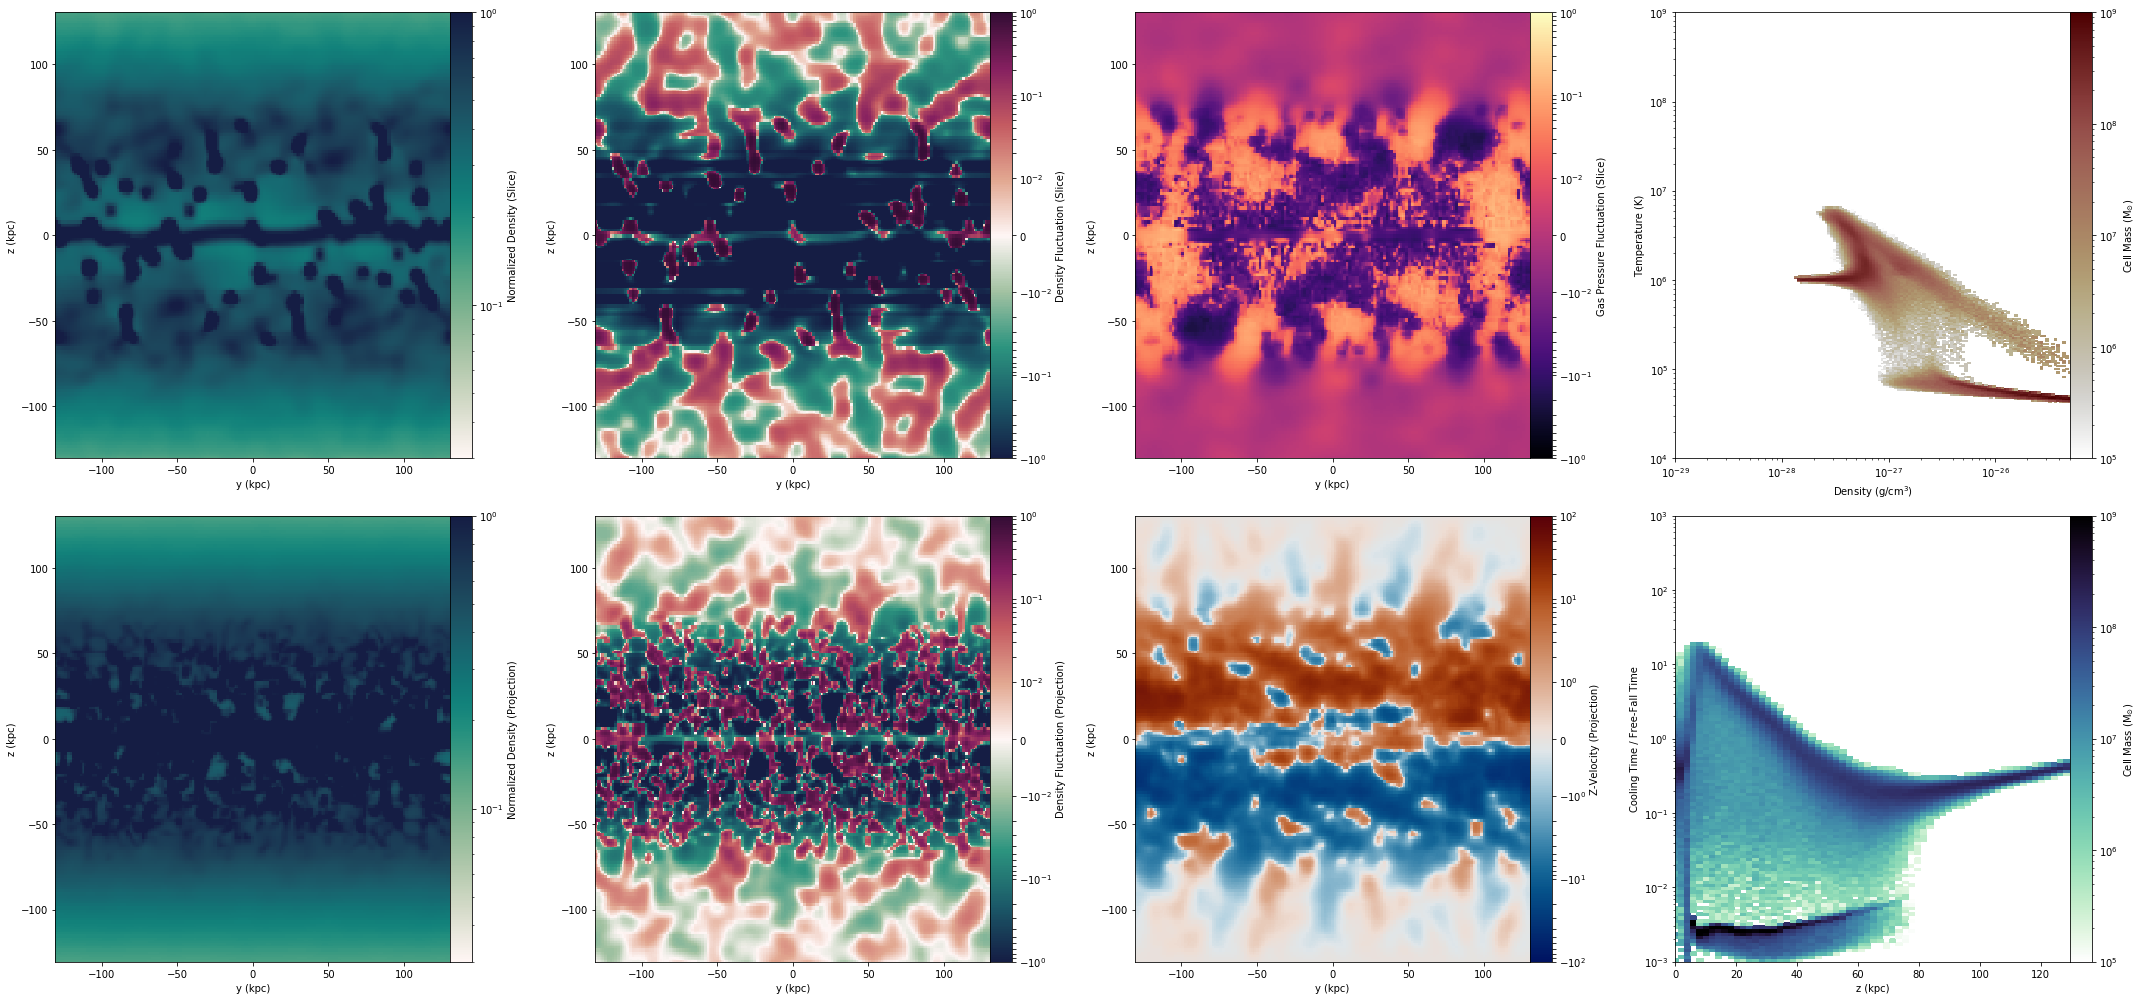

In [6]:
i = 52
folder = 'isothermal_tctf_0.1_beta_10.0_cr_1.0_stream_heat'
folder = 'isothermal_tctf_0.1_test'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))

fig, ax = pt.plot_density_slices(ds)


yt : [INFO     ] 2019-12-08 07:54:16,421 Parameters: current_time              = 0.51999990071769
yt : [INFO     ] 2019-12-08 07:54:16,422 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-12-08 07:54:16,422 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-12-08 07:54:16,423 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-12-08 07:54:16,424 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-08 07:54:16,441 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-12-08 07:54:17,285 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:54:17,287 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:54:17,288 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:54:17,289 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-08 07:54:17,290 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-12-08 07:54:17,302 Making a fixed resolution b

0


yt : [INFO     ] 2019-12-08 07:55:14,200 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-12-08 07:55:14,604 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-12-08 07:55:15,171 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-12-08 07:55:19,478 Projection completed
yt : [INFO     ] 2019-12-08 07:55:19,488 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-12-08 07:55:23,815 Projection completed
yt : [INFO     ] 2019-12-08 07:55:23,828 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2019-12-08 07:55:24,405 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2019-12-08 07:55:29,054 Projection completed


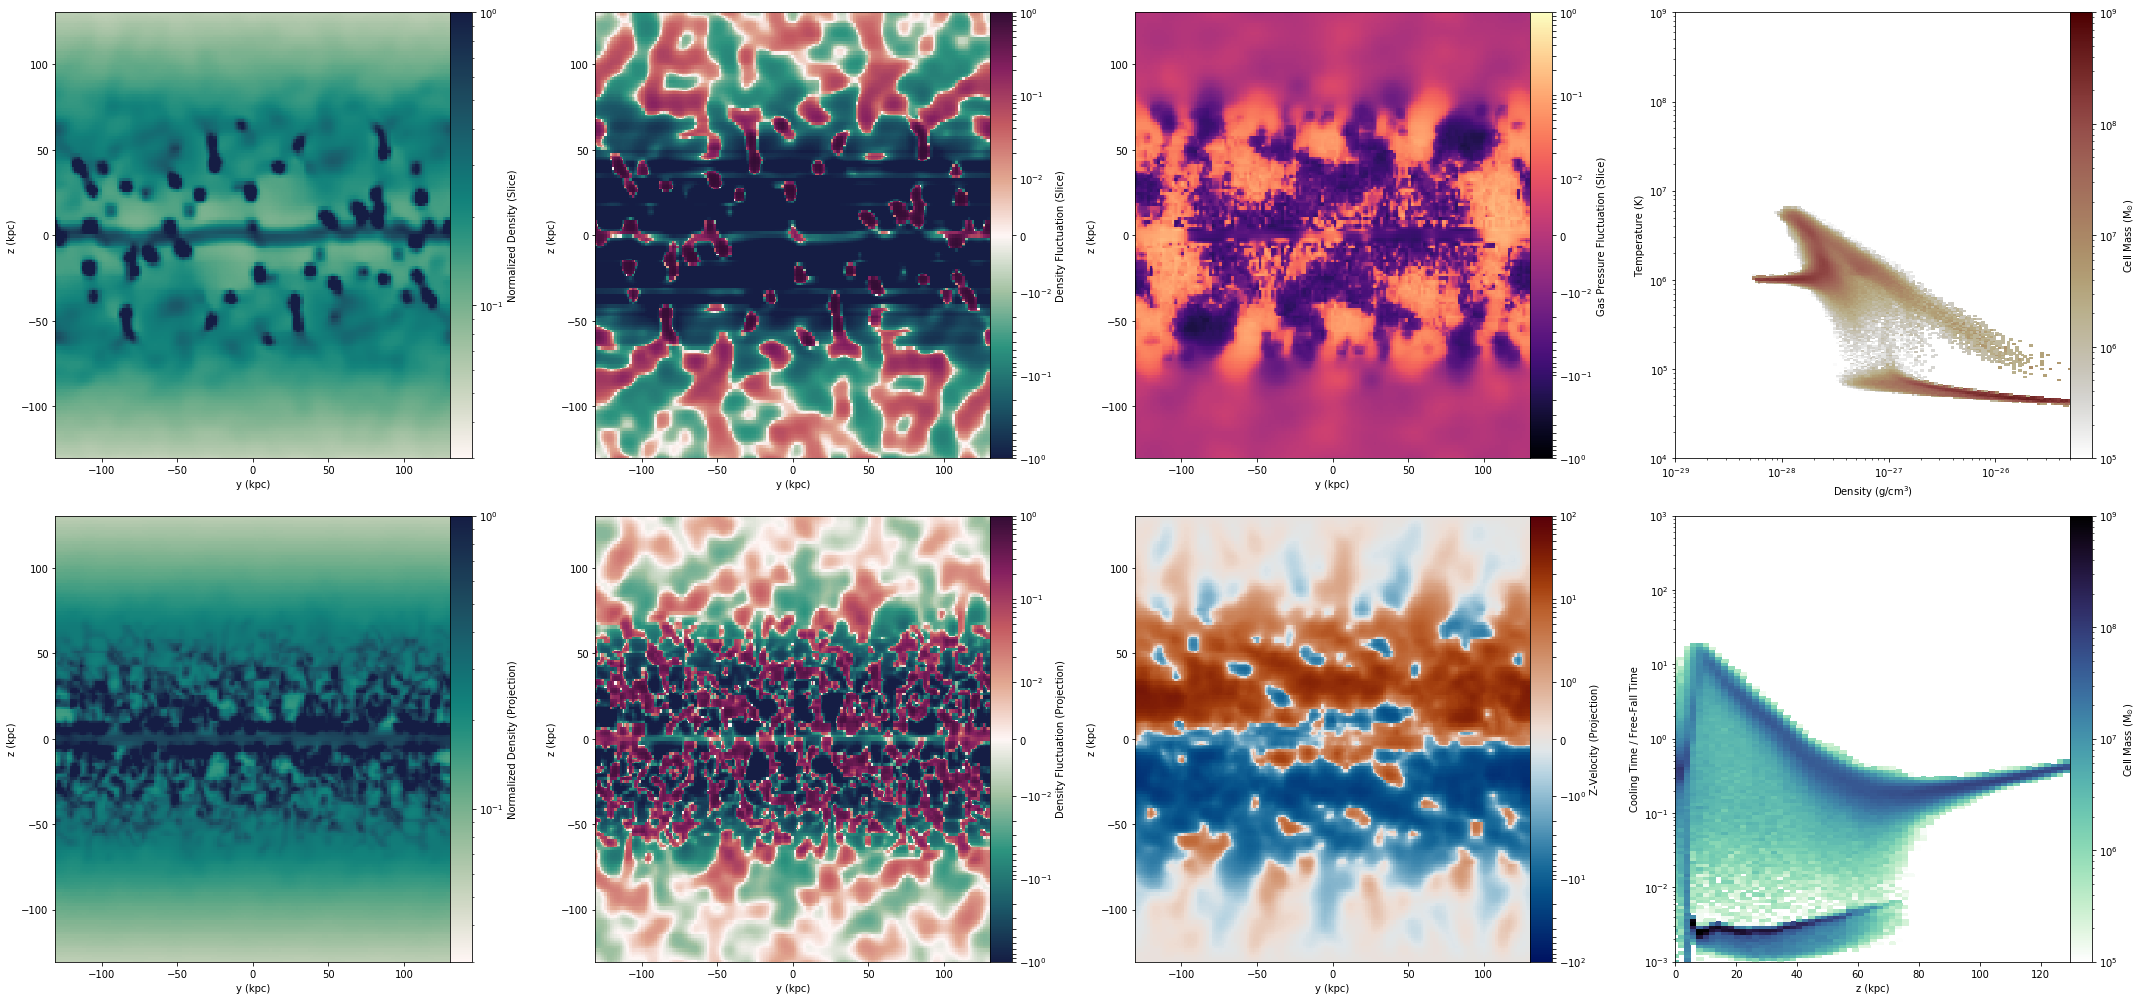

In [8]:
i = 52
folder = 'isothermal_tctf_0.1_beta_10.0_cr_1.0_stream_heat'
folder = 'no_center_heating/isothermal_tctf_0.1'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))

fig, ax = pt.plot_density_slices(ds)


yt : [INFO     ] 2019-12-03 14:22:56,413 Parameters: current_time              = 0.050000229918279
yt : [INFO     ] 2019-12-03 14:22:56,414 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-12-03 14:22:56,416 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-12-03 14:22:56,417 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-12-03 14:22:56,417 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-03 14:22:56,424 Gathering a field list (this may take a moment.)
/home/ibutsky/yt/yt/units/yt_array.py:1400: RuntimeWarning: divide by zero encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2019-12-03 14:22:57,242 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:22:57,243 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:22:57,243 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:22:57,244 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:22:57,245 Making a fix


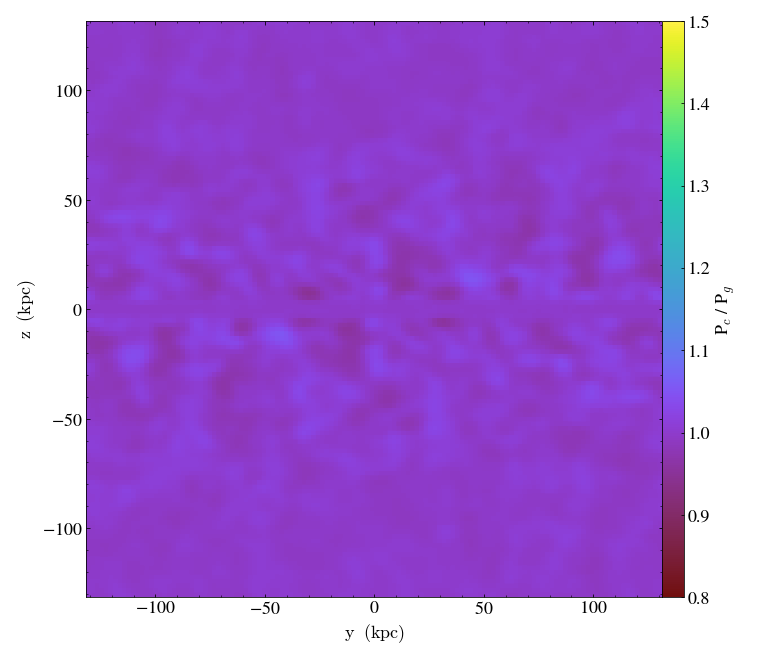
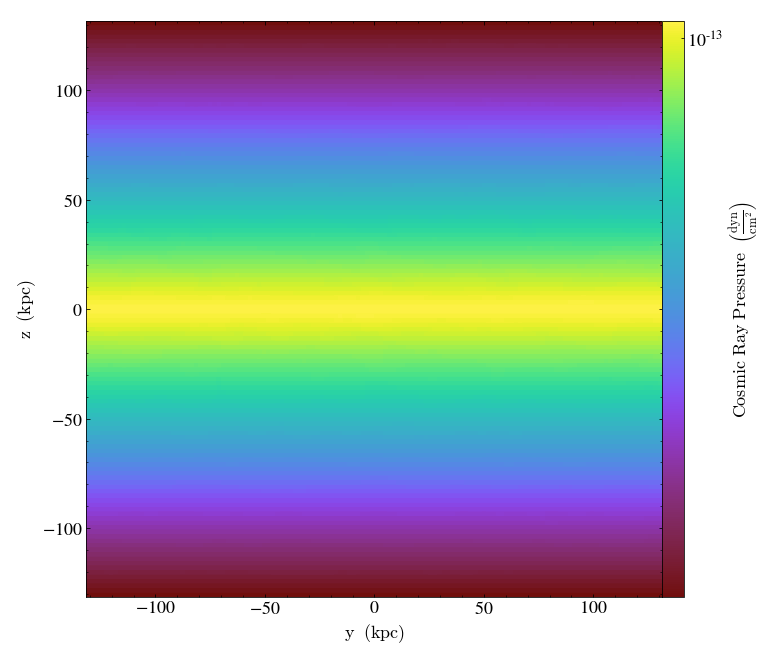

yt : [INFO     ] 2019-12-03 14:23:07,176 Parameters: current_time              = 0.050000229114963
yt : [INFO     ] 2019-12-03 14:23:07,177 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-12-03 14:23:07,178 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-12-03 14:23:07,179 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-12-03 14:23:07,180 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-03 14:23:07,184 Gathering a field list (this may take a moment.)
/home/ibutsky/yt/yt/units/yt_array.py:1400: RuntimeWarning: divide by zero encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2019-12-03 14:23:07,820 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:23:07,821 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:23:07,822 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:23:07,822 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-12-03 14:23:07,823 Making a fix


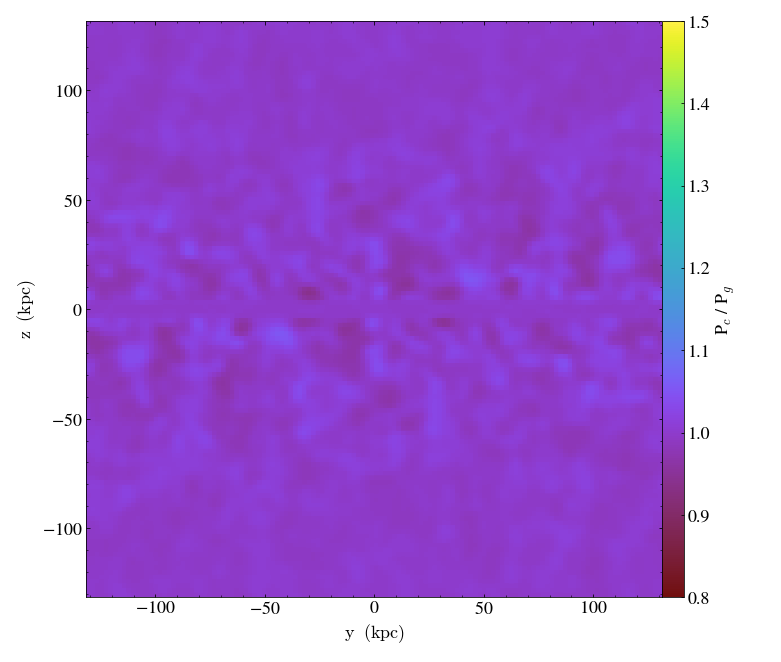

In [34]:
i = 5

folder = 'isothermal_tctf_0.1_beta_10.0_cr_1.0_stream_heat'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
field_list = [('gas', 'cr_eta'), ('gas', 'cr_pressure')]
s = yt.SlicePlot(ds, 'x', field_list)
s.set_zlim(('gas', 'cr_eta'), 8e-1, 1.5)
s.set_log(('gas', 'cr_eta'), False)
s.show()



folder = 'isothermal_tctf_0.1_beta_10.0_cr_1.0'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
field_list = [('gas', 'cr_eta')]
s = yt.SlicePlot(ds, 'x', field_list)
s.set_zlim(('gas', 'cr_eta'), 8e-1, 1.5)
s.set_log(('gas', 'cr_eta'), False)
s.show()





In [32]:
dt = 0.25 * dx**2 / vs / (50*dx)

0.00999966667999946

In [25]:
h = 10 #pc
dx = 160 # minimum

print(h/dx )

dx2 = 0.07 * 6 / 128

dx2

0.0625


0.0032812500000000003

yt : [INFO     ] 2019-11-06 13:20:07,985 Parameters: current_time              = 4.9999990048207
yt : [INFO     ] 2019-11-06 13:20:07,986 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-06 13:20:07,986 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-11-06 13:20:07,987 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-11-06 13:20:07,988 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-06 13:20:07,992 Gathering a field list (this may take a moment.)
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:67: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'External Acceleration Z', units = 'cm/s**2')
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:70: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Free Fall Time', units = 's')
/simo


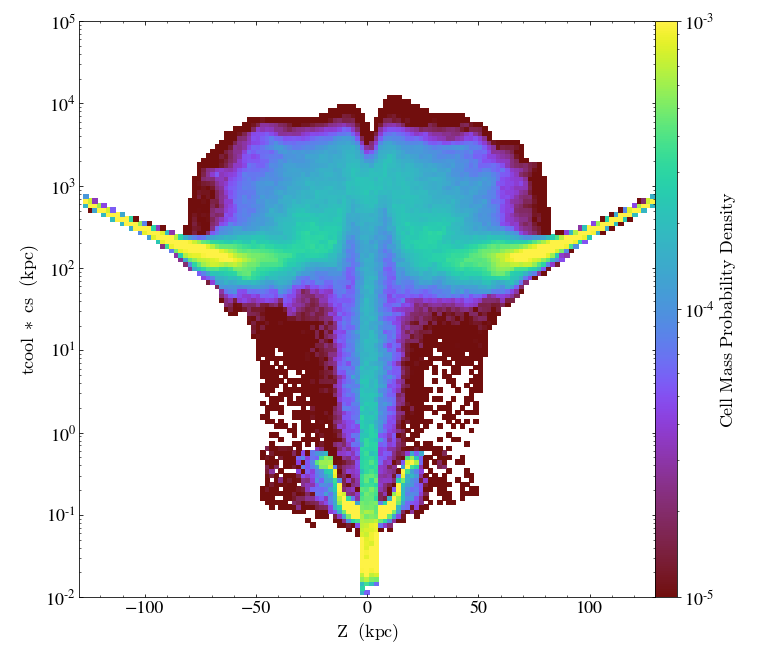

In [65]:
def _tcool_cs(field, data):
    return data[('gas', 'cooling_time')] * data[('gas', 'sound_speed')]

i = 50
folder = 'isothermal_tctf_1.0'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
ds.add_field(('gas', 'tcool_cs'), function = _tcool_cs, \
                        display_name = 'tcool * cs', units = 'kpc')

ad = ds.all_data()

ph = yt.PhasePlot(ad, ('gas', 'z'), ('gas', 'tcool_cs'), ('gas', 'cell_mass'),\
                  weight_field = None, fractional = True)
ph.set_unit(('gas', 'z'), 'kpc')
ph.set_log(('gas', 'z'), False)
ph.set_ylim(1e-2, 1e5)
ph.set_zlim(('gas', 'cell_mass'), 1e-5, 1e-3)
ph.show()


In [2]:
# note: calculate effective entropy and see if it decreases with height

def _gasentropy(field, data):
    gamma = 5./3.
    mh     = YTQuantity(const.m_p.cgs.value, 'g')
    mu = 1.22
    
    p = data[('gas', 'pressure')]
    n = data[('gas', 'density')] / (mu * mh)
    return  p / np.power(n, gamma)

def _crentropy(field, data):
    crgamma = 4./3.
    mh     = YTQuantity(const.m_p.cgs.value, 'g')
    mu = 1.22
    
    pcr = data[('gas', 'cr_pressure')]
    n = data[('gas', 'density')] / (mu * mh)
    return  pcr / np.power(n, crgamma)
 
    
i = 30
folder = 'isothermal_tctf_1.0_beta_10.0_cr_3.0'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
#ds.add_field(('gas', 'gas_entropy'), function = _gasentropy, units = 'cm**2 * keV', force_override = True)
#ds.add_field(('gas', 'cr_entropy'), function = _crentropy, units = 'cm**2 * keV', force_override = True)
ad = ds.all_data()
print(ad[('gas', 'gas_entropy')])
print(ad[('gas', 'cr_entropy')])


yt : [INFO     ] 2019-11-04 11:09:28,323 Parameters: current_time              = 2.9999990210575
yt : [INFO     ] 2019-11-04 11:09:28,324 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-04 11:09:28,326 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-11-04 11:09:28,327 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-11-04 11:09:28,328 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-04 11:09:28,333 Gathering a field list (this may take a moment.)
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:66: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'External Acceleration Z', units = 'cm/s**2')
/simons/scratch/ibutsky/thermal_instabilities/analysis/yt_functions.py:69: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  display_name = 'Free Fall Time', units = 's')
/simo

[96.6254488  95.19369973 93.792479   ... 88.66054597 89.59976932
 90.52982845] cm**2*keV
[1.32668515e-08 1.32315855e-08 1.31945631e-08 ... 1.32587964e-08
 1.33052818e-08 1.33507097e-08] cm**2*dyne


yt : [INFO     ] 2019-11-04 11:23:04,724 Parameters: current_time              = 4.9999990761866
yt : [INFO     ] 2019-11-04 11:23:04,725 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-11-04 11:23:04,726 Parameters: domain_left_edge          = [-2. -2. -2.]
yt : [INFO     ] 2019-11-04 11:23:04,727 Parameters: domain_right_edge         = [2. 2. 2.]
yt : [INFO     ] 2019-11-04 11:23:04,728 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-11-04 11:23:04,746 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2019-11-04 11:23:05,527 Field ('gas', 'log_total_entropy') already exists. To override use force_override=True.


(3, 6)

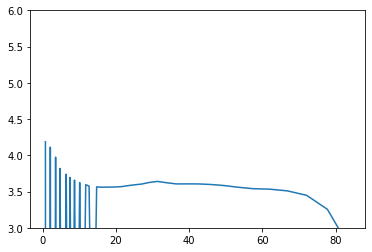

In [20]:

i = 1
folder = 'isothermal_tctf_0.1'
ds = ytf.load('../../simulations/%s/DD%04d/DD%04d'%(folder, i, i))
ad = ds.all_data()
p = yt.ProfilePlot(ad, ('gas', 'z'), [('gas', 'log_total_entropy')])#, ('gas','cr_entropy')])#, ('gas', 'cr_eta')])
p.set_unit(('gas', 'z'), 'kpc')
p.set_log(('gas', 'z'), False)
profile = p.profiles[0]


#ge = profile[('gas', 'gas_entropy')]
#ce = profile[('gas', 'cr_entropy')]
#eta = profile[('gas', 'cr_eta')]
z = ad[('gas', 'z')]
y = profile[('gas', 'log_total_entropy')]
#y = np.log10(ge) + eta*np.log10(ce)

plt.plot(profile.x, y)
plt.ylim(3, 6)

#plt.yscale('log')



In [6]:
i = 0
ds1 = ytf.load('../../simulations/isothermal_tctf_1.0/DD%04d/DD%04d'%(i, i))
#ds2 = ytf.load('../../simulations/isothermal_tctf_1.0_beta_10.0/DD%04d/DD%04d'%(i, i))
ds2 = ytf.load('../../simulations/isothermal_tctf_1.0_beta_10.0_cr_3.0/DD%04d/DD%04d'%(i, i))
ad = ds1.all_data()
ad2 = ds2.all_data()

z = ad[('gas', 'z')].in_units('kpc')
ptot1 = ad[('gas', 'pressure')] + ad[('gas', 'magnetic_pressure')]
ptot2 = ad2[('gas', 'pressure')] + ad2[('gas', 'magnetic_pressure')] + ad2[('gas', 'cr_pressure')]

print("ptot1 / ptot2", ptot1/ ptot2)

print("pgas1 / pgas2", ad[('gas', 'pressure')] / ad2[('gas', 'pressure')])

print(ad2[('gas', 'cr_eta')], ad2[('gas', 'plasma_beta')])
print(ad2[('gas', 'pressure')] / ad2[('gas', 'magnetic_pressure')])
#print(ad[field] / ad2[field])

#ad2[('gas', 'cr_eta')]


yt : [INFO     ] 2019-10-29 07:17:57,835 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-29 07:17:57,836 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-29 07:17:57,837 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-29 07:17:57,839 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-29 07:17:57,840 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-29 07:17:58,088 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-10-29 07:17:59,015 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-29 07:17:59,016 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-29 07:17:59,017 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-29 07:17:59,018 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-29 07:17:59,019 Parameters: cosmological_simulation   = 0.0
yt : [INFO

ptot1 / ptot2 [0.22493004 0.23304024 0.2414427  ... 0.2414427  0.23304024 0.22493004] dimensionless
pgas1 / pgas2 [0.92220966 0.95546136 0.98991134 ... 0.98991134 0.95546136 0.92220966] dimensionless
[2.999985 2.999985 2.999985 ... 2.999985 2.999985 2.999985] dimensionless [10.00005 10.00005 10.00005 ... 10.00005 10.00005 10.00005] dimensionless
[10.00005 10.00005 10.00005 ... 10.00005 10.00005 10.00005] dimensionless


In [18]:
ds = ytf.load('../../simulations/isocool_tctf_0.3_2d_256/DD0000/DD0000')
ad = ds.all_data()
field_list = [('gas', 'temperature'), ('gas', 'density')]
p = yt.ProfilePlot(ad, ('gas', 'z'), field_list)
p.set_unit(('gas', 'z'), 'kpc')
p.set_log(('gas', 'z'), False)
#p.show()

profile = p.profiles[0]
pz = profile.x
temp = profile[('gas', 'temperature')]
dens = profile[('gas', 'density')]


#plt.semilogy(pz, py)#.in_units('yr'))
#plt.scatter(43.85, 9.86e-29)
for z, T, rho in zip(pz, temp, dens):
    print(z, T, rho)#y.in_units('yr'))


yt : [INFO     ] 2019-12-12 13:15:22,016 Parameters: current_time              = 0
yt : [INFO     ] 2019-12-12 13:15:22,017 Parameters: domain_dimensions         = [  4 256 256]
yt : [INFO     ] 2019-12-12 13:15:22,018 Parameters: domain_left_edge          = [-0.03125 -2.      -2.     ]
yt : [INFO     ] 2019-12-12 13:15:22,019 Parameters: domain_right_edge         = [0.03125 2.      2.     ]
yt : [INFO     ] 2019-12-12 13:15:22,019 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-12 13:15:22,024 Gathering a field list (this may take a moment.)


0.3580988974372982 kpc 1997388.9783133746 K 3.1605534756910557e-27 g/cm**3
0.39048573595505975 kpc 0.0 K 0.0 g/cm**3
0.42580167399443974 kpc 0.0 K 0.0 g/cm**3
0.4643116223772492 kpc 0.0 K 0.0 g/cm**3
0.5063044507368666 kpc 0.0 K 0.0 g/cm**3
0.5520951543781984 kpc 0.0 K 0.0 g/cm**3
0.6020272171107188 kpc 0.0 K 0.0 g/cm**3
0.6564751877785882 kpc 0.0 K 0.0 g/cm**3
0.7158474898148581 kpc 0.0 K 0.0 g/cm**3
0.7805894848946939 kpc 0.0 K 0.0 g/cm**3
0.8511868136685842 kpc 0.0 K 0.0 g/cm**3
0.9281690386349697 kpc 0.0 K 0.0 g/cm**3
1.0121136164780793 kpc 1995215.9036429098 K 3.156390681114338e-27 g/cm**3
1.1036502296681354 kpc 0.0 K 0.0 g/cm**3
1.2034655098160205 kpc 0.0 K 0.0 g/cm**3
1.3123081882130743 kpc 0.0 K 0.0 g/cm**3
1.4309947121910978 kpc 0.0 K 0.0 g/cm**3
1.560415369431801 kpc 0.0 K 0.0 g/cm**3
1.7015409661652294 kpc 1990815.422980483 K 3.1486714588467754e-27 g/cm**3
1.8554301093514325 kpc 0.0 K 0.0 g/cm**3
2.0232371474702244 kpc 0.0 K 0.0 g/cm**3
2.2062208294842933 kpc 0.0 K 0.0 g/cm*

In [21]:
10.0 / 0.5 #np.power(0.50110694, 1.0 + 2./3.)

20.0

yt : [INFO     ] 2019-12-12 14:05:01,458 Parameters: current_time              = 0.029999707480501
yt : [INFO     ] 2019-12-12 14:05:01,459 Parameters: domain_dimensions         = [  4 256 256]
yt : [INFO     ] 2019-12-12 14:05:01,460 Parameters: domain_left_edge          = [-0.03125 -2.      -2.     ]
yt : [INFO     ] 2019-12-12 14:05:01,461 Parameters: domain_right_edge         = [0.03125 2.      2.     ]
yt : [INFO     ] 2019-12-12 14:05:01,462 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-12 14:05:01,470 Gathering a field list (this may take a moment.)
/home/ibutsky/yt/yt/units/yt_array.py:1400: RuntimeWarning: divide by zero encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2019-12-12 14:05:02,122 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-12-12 14:05:02,123 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-12-12 14:05:02,124 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-12-12 14:05:02,124 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-1


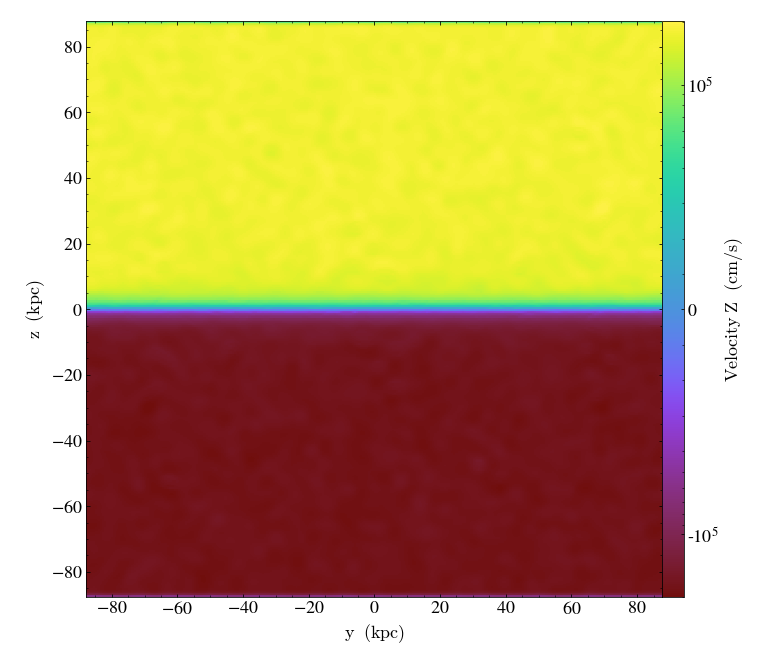

In [30]:
ds = ytf.load('../../simulations/isocool_tctf_0.3_2d_256/DD0001/DD0001')

s = yt.SlicePlot(ds, 'x', ('gas', 'velocity_z'))
s.show()

In [12]:
ds = ytf.load('../../simulations/isocool_tctf_0.3_2d_256/DD0000/DD0000')
ad = ds.all_data()
field_list = [('gas', 'temperature'), ('gas', 'density')]
p = yt.ProfilePlot(ad, ('gas', 'z'), field_list)
p.set_unit(('gas', 'z'), 'kpc')
p.set_log(('gas', 'z'), False)
#p.show()

profile = p.profiles[0]
pz = profile.x
temp = profile[('gas', 'temperature')]
dens = profile[('gas', 'density')]


#plt.semilogy(pz, py)#.in_units('yr'))
#plt.scatter(43.85, 9.86e-29)
for z, T, rho in zip(pz, temp, dens):
    print(z, T, rho)#y.in_units('yr'))


yt : [INFO     ] 2019-12-12 13:04:08,832 Parameters: current_time              = 0
yt : [INFO     ] 2019-12-12 13:04:08,833 Parameters: domain_dimensions         = [  4 256 256]
yt : [INFO     ] 2019-12-12 13:04:08,834 Parameters: domain_left_edge          = [-0.03125 -2.      -2.     ]
yt : [INFO     ] 2019-12-12 13:04:08,835 Parameters: domain_right_edge         = [0.03125 2.      2.     ]
yt : [INFO     ] 2019-12-12 13:04:08,835 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-12-12 13:04:08,842 Gathering a field list (this may take a moment.)
/home/ibutsky/yt/yt/units/yt_array.py:1400: RuntimeWarning: divide by zero encountered in true_divide
  out=out, **kwargs)


0.3580988974372982 kpc 1515135.7277069276 K 1.994089402234989e-27 g/cm**3
0.39048573595505975 kpc 0.0 K 0.0 g/cm**3
0.42580167399443974 kpc 0.0 K 0.0 g/cm**3
0.4643116223772492 kpc 0.0 K 0.0 g/cm**3
0.5063044507368666 kpc 0.0 K 0.0 g/cm**3
0.5520951543781984 kpc 0.0 K 0.0 g/cm**3
0.6020272171107188 kpc 0.0 K 0.0 g/cm**3
0.6564751877785882 kpc 0.0 K 0.0 g/cm**3
0.7158474898148581 kpc 0.0 K 0.0 g/cm**3
0.7805894848946939 kpc 0.0 K 0.0 g/cm**3
0.8511868136685842 kpc 0.0 K 0.0 g/cm**3
0.9281690386349697 kpc 0.0 K 0.0 g/cm**3
1.0121136164780793 kpc 1513951.0886741753 K 1.9924801162148964e-27 g/cm**3
1.1036502296681354 kpc 0.0 K 0.0 g/cm**3
1.2034655098160205 kpc 0.0 K 0.0 g/cm**3
1.3123081882130743 kpc 0.0 K 0.0 g/cm**3
1.4309947121910978 kpc 0.0 K 0.0 g/cm**3
1.560415369431801 kpc 0.0 K 0.0 g/cm**3
1.7015409661652294 kpc 1511508.824461716 K 1.9895743068601045e-27 g/cm**3
1.8554301093514325 kpc 0.0 K 0.0 g/cm**3
2.0232371474702244 kpc 0.0 K 0.0 g/cm**3
2.2062208294842933 kpc 0.0 K 0.0 g/cm*